# <Font color = 'indianred'>**Sentiment Analysis using Hugging Face Ecosystem** </font>

**Objective**: We will now enhance our sentiment analysis notebook for IMDb dataset by adopting the Hugging Face ecosystem. Hugging Face ecosystem provides a range of efficient tools and utilities that complement PyTorch's flexibility, facilitating easier implementation of NLP tasks. We will make the following changes

1. **Model Adaptation**: We'll tweak our model class for compatibility with the Hugging Face ecosystem.

2. **Streamlined Data Handling**: We will use Hugging Face Datasets library to load and preprocess the IMDb dataset , This will eliminate the need for creating custom dataset class. We will still need to create Vocab and collate function.

3. **Eliminate Training Loops**: We will use Hugging Face Trainer to handle the training process automatically. This will eliminate the need for creating our own custom functions for training loops.

4. **Efficient Model Management**: The Trainer also simplifies saving and loading models, with features like tracking and saving the 'Best Model'. Unlike our previous method of evaluating after every epoch, the Trainer offers the flexibility to evaluate and save model at various intervals.

5. **Better integration of evaluation metrics**: In the previous notebook, incorporating additional metrics like accuracy (for model evaluation during training) required manual code changes. We will now use **evaluate library**, that will help us to  seamlessly include various metrics, and the Trainer automatically computes them during the evaluation phase. This setup significantly simplifies the process of model performance assessment and comparison, making it more flexible and less error-prone.

6. **Enhanced Experiment Tracking**: We will also incorporate Weights & Biases (WandB) for robust experiment tracking, enabling real-time logging of training metrics, hyperparameters, and outputs, making it much easier to compare different models and runs.

**Plan**:
1. Set Environment: Load libraries needed and specify folders for saving dataset and model.
2. Load Data: Load the moview review data from files provided.
3. Create Huggingface Dataset
4. Create Custom Model and Model Config Class
5. Train Model
  1. Collate Function <br>
  2. Instantiate Model <br>
  3. Compute Metric Function <br>
  4. Training Arguments <br>
  5. Instantiate Trainer <br>
  6. Setup WandB <br>
  7. Training and Validation
6. Perfromance on Test Set
7. Model Inference

<br>

**Previous Workflow**

<img src ="https://drive.google.com/uc?export=view&id=1GShf7FdfqkmedOFINDsQTwDF2Txj2dDv" width =800>


<br><br>

**Revised Workflow**

<img src ="https://drive.google.com/uc?export=view&id=1Q9F-oqg69v_fLOv5vK6LV5pPMatEg43Z" width =500>

## <Font color = 'indianred'>**1. Set Environment**

In this notebook, we have to install following additional libraries (compared to previous notebooks) from Huggingface  to enhance our workflow: **transformers**, **datasets**, **evaluate**, and **accelearte**. In addition, we are also installing **wandb**.

- The transformers library provides **Trainer** class that we will use to manage Training process.
- The **datasets** library simplifies the process of accessing and manipulating a wide array of datasets.
- The **evaluate** library offers a suite of standardized metrics and methods for robust and consistent model evaluation.
- We will not use **accelerate** library directly. However , we need to install it as transformer librray usses it in the background.
- Finally **wandb** library provide tools for efficient experiment tracking.

In [ ]:
# If in Colab, then import the drive module from google.colab
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  # Mount the Google Drive to access files stored there
  drive.mount('/content/drive')

  # Install the latest version of torchtext library quietly without showing output
  !pip install torchtext -qq
  !pip install transformers evaluate wandb datasets accelerate -U -qq ## NEW LINES ##
  basepath = '/content/drive/MyDrive/data/'
else:
  basepath = '/home/harpreet/Insync/google_drive_shaannorr/data'



Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 62.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 61.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 93.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.8 MB/s eta 0:

In [ ]:
# Importing PyTorch library for tensor computations and neural network modules
import torch
import torch.nn as nn

# For working with textual data vocabularies and for displaying model summaries
from torchtext.vocab import vocab

# General-purpose Python libraries for random number generation and numerical operations
import random
import numpy as np

# Utilities for efficient serialization/deserialization of Python objects and for element tallying
import joblib
from collections import Counter

# For creating lightweight attribute classes and for partial function application
from functools import partial

# For filesystem path handling, generating and displaying confusion matrices, and date-time manipulations
from pathlib import Path
from sklearn.metrics import confusion_matrix
from datetime import datetime

# For plotting and visualization
import matplotlib.pyplot as plt
import seaborn as sns
# %matplotlib inline

### NEW ##########################
# imports from Huggingface ecosystem
from transformers.modeling_outputs import SequenceClassifierOutput
from transformers import PreTrainedModel, PretrainedConfig
from transformers import TrainingArguments, Trainer
from datasets import Dataset
import evaluate

# wandb library
import wandb

- `from transformers.modeling_outputs import SequenceClassifierOutput`: This import provides a specific output format for sequence classification tasks required by Huggingface Trainer. We will use this in our custom model.
- `from transformers import PreTrainedModel, PretrainedConfig`: All models should be subclass of `PreTrainedModel` for the model to work with Trainer. We will also need to create a config file for the model which should be subclass of `PretrainedConfig.`
- `from transformers import TrainingArguments, Trainer`: `TrainingArguments` is used to define training hyperparameters, while `Trainer` is a high-level API for training, fine-tuning, and evaluating models easily.
- `from datasets import Dataset`: This import from the `datasets` library is used to handle datasets more efficiently.
- `import evaluate`: This import brings in the `evaluate` library that offers various metrics to assess the performance of NLP models.
`import wandb`: This import integrates the Weights & Biases library, a tool for experiment tracking.



<Font color = 'indianred'>*Specify Project Folders*

In [ ]:
base_folder = Path(basepath)
data_folder = base_folder/'datasets/aclImdb'
model_folder = base_folder/'models/nlp_spring_2024/imdb/nn'
custom_functions = base_folder/'custom-functions'

In [ ]:
model_folder.mkdir(exist_ok=True, parents = True)

In [ ]:
model_folder

PosixPath('/content/drive/MyDrive/data/models/nlp_spring_2024/imdb/nn')

## <Font color = 'indianred'>**2. Load Data** </font>

**IMDB movie review dataset**

For this tutorial, we are using the *IMDB movie review dataset*, which is widely recognized for sentiment analysis tasks. It consists of movie reviews from the IMDB website.

- This is a dataset for binary sentiment classification i.e. it has two outputes (positive sentiment and negative sentiment). The dataset has a set of 25,000 movie reviews for training, and 25,000 for testing.

- The labels for this dataset are binary, reflecting positive or negative sentiments. A label of '0' typically represents a negative sentiment, while a label of '1' signifies a positive sentiment.

- The dataset can be accessed via the following link: http://ai.stanford.edu/~amaas/data/sentiment/

**Data Preprocessing Steps Undertaken:**

1. **Initial Cleaning:** We cleaned the raw data by removing HTML tags, punctuation, and standardizing the text to lowercase to ensure uniformity and aid model training.

2. **Dataset Splits:** We divided the dataset into training, validation, and test sets. This separation is crucial for training, fine-tuning, and objectively evaluating the performance of our models.

3. **Serialization of Data:** To facilitate ease of access during model training and testing, we serialized the processed splits into separate files using the `joblib` library.

**Files provided**

To facilitate your work with this dataset, we have provided three serialized files corresponding to the training, validation, and test splits. Each file contains a tuple, where:

- The first element is a list of reviews, representing the preprocessed textual data from movie reviews.
- The second element is a numpy array of labels, where each label corresponds to the sentiment of a review (0 for negative, 1 for positive).

<Font color = 'indianred'>*Load cleaned arrays from files using joblib*

In [ ]:
X_train_cleaned_file = data_folder / 'x_train_cleaned.pkl'
X_valid_cleaned_file = data_folder / 'x_valid_cleaned.pkl'
X_test_cleaned_file = data_folder / 'x_test_cleaned.pkl'

In [ ]:
X_train_cleaned, y_train = joblib.load(X_train_cleaned_file)
X_valid_cleaned, y_valid = joblib.load(X_valid_cleaned_file)
X_test_cleaned, y_test = joblib.load(X_test_cleaned_file)

In [ ]:
type(y_train)

numpy.ndarray

In [ ]:
type(X_train_cleaned)

list

## <Font color = 'indianred'>**3. Create Huggingface Dataset**

*Comaprison with previous approach*

**In the previous notebook, 4_imdb_complete_example.ipynb, a custom dataset class was created**, typically involving more code. This approach required manually defining a class inheriting from PyTorch's Dataset class and implementing methods like `__getitem__` and `__len__`.

In contrast, the Hugging Face datasets approach simplifies this process significantly. It abstracts away the need for a custom class and manual handling of data access patterns. This not only reduces the code complexity but also provides a standardized, efficient way to handle datasets.

In [ ]:
trainset = Dataset.from_dict({
    'texts': X_train_cleaned,
    'labels': y_train
})

validset = Dataset.from_dict({
    'texts': X_valid_cleaned,
    'labels': y_valid
})

testset = Dataset.from_dict({
    'texts': X_test_cleaned,
    'labels': y_test
})

*Explanation of Dataset Creation*

- Initially, we imported the `Dataset` class from the `datasets`
- The `from_dict` method constructs a - `Dataset` object from a Python dictionary.

*Advantages of Using `Dataset` Object*
- **Handling Different Data Sources**: Whether the data comes from arrays, CSV files, Pandas DataFrames, or JSON files, the Dataset object can be created in a similar manner. This uniformity in handling different data sources simplifies the data preparation process.

- **Efficient Transition to Training**: Once the data is structured into a Dataset object, it can be directly utilized for training models using the Hugging Face Trainer class. This integration streamlines the workflow from data processing to model training. *We do not need to create DataLaoders*. We will still need to provide collate function to Trainer.



<Font color = 'indianred'>*Understand and Explore Dataset*

In [ ]:
trainset

Dataset({
    features: ['texts', 'labels'],
    num_rows: 20000
})

- The word `Dataset` indicates that this object is an instance of the `Dataset` class from the Hugging Face `datasets` library.

- `'features: ['texts', 'labels']'`: This part lists the features (or columns) present in the dataset. In this case, there are two features:
     - `'texts'`: Represents the input data, which in this contextis the preprocessed movie reviews.
     - `'labels'`: Denotes the target labels associated with each text entry.

- `'num_rows: 20000'`: This indicates the total number of entries (or rows) in the dataset.


In [ ]:
trainset.features

{'texts': Value(dtype='string', id=None),
 'labels': Value(dtype='int64', id=None)}

The `trainset.features` output provides a concise description of the dataset's features:

- `'texts'`: This feature contains text data, indicated by its data type being `'string'`.
- `'labels'`: This feature holds integer labels (`'int64'`), representing categories or classes for each text entry.


In [ ]:
trainset[1]

{'texts': 'horror movie alright let start kate main goal include get lay george clooney look good screw got to love 3 amazingly good chance finish sicko instead run mean wanna bring guy 10 minute late mean guy try rape not movie main character sad idiot mean honestly sympathy guy finish meet night movie keep go result lose credibility',
 'labels': 0}

`trainset[1]`: This retrieves a single entry from the trainset dataset, specifically the second entry (as indexing starts from 0). The result is a dictionary containing two keys: 'texts', which holds the text of the review, and 'labels', which contains the sentiment label (either a positive or negative sentiment, typically represented by an integer).



In [ ]:
trainset[0]['texts']

'george brent reporter send interview heiress supposedly heir face cream fortune interview yacht fall bathe costume turn early heiress advertising campaign cold cream movie follow up down romance support cast little buoy davis brent carry picture fairly predictable fairly entertaining far good especially consider obscurity oeuvre bad'

-  `trainset[0]['texts']` first selects the 'texts' column from the dataset and then accesses the first text entry within that column.

## <Font color = 'indianred'>**4. Create Custom Model and Model Config Class** </font>
embedding_layer-->linear--> ReLU -->dropout --> batch norm --> linear-->ReLu-->Dropout--> batchnorm ---> linear layer

The new `CustomMLP` model represents a significant adaptation to align with the conventions of the Hugging Face ecosystem, which differs from traditional PyTorch models in several key ways:

### High-Level Changes for Hugging Face Compatibility:

1. **Output of Both Loss and Logits**:
   - In the Hugging Face framework, models typically output both the loss and the logits, as opposed to traditional models which might only output logits.

2. **Requirement of a Configuration Class**:
   - Hugging Face models rely on a configuration class, like `CustomConfig`, to handle various model settings and hyperparameters. This configuration class is essential for defining model-specific parameters and ensures that the model can be easily adjusted, saved, and loaded with these configurations.

3. **Inheritance from `PreTrainedModel`**:
   - Models in the Hugging Face ecosystem are typically subclasses of `PreTrainedModel` rather than the standard `nn.Module` used in PyTorch. This subclassing provides additional functionalities crucial for Hugging Face models, such as compatibility with pre-trained weights, standardized methods for loading/saving models, and integration with the rest of the Hugging Face libraries.

In [ ]:
class CustomConfig(PretrainedConfig):
  def __init__(self, vocab_size=0, embedding_dim=0, hidden_dim1=0, hidden_dim2=0, num_labels=2, **kwargs):
      super().__init__()
      self.vocab_size = vocab_size
      self.embedding_dim = embedding_dim
      self.hidden_dim1 = hidden_dim1
      self.hidden_dim2 = hidden_dim2
      self.num_labels = num_labels

* `**kwargs` allows the class to accept any additional configuration attributes that are not part of the standard set of attributes defined in the class, providing flexibility and extensibility.

In [ ]:
class CustomMLP(PreTrainedModel):
    config_class = CustomConfig

    def __init__(self, config):
        super().__init__(config)

        self.embedding_bag = nn.EmbeddingBag(config.vocab_size, config.embedding_dim)
        self.layers = nn.Sequential(
            nn.Linear(config.embedding_dim, config.hidden_dim1),
            nn.BatchNorm1d(num_features=config.hidden_dim1),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(config.hidden_dim1, config.hidden_dim2),
            nn.BatchNorm1d(num_features=config.hidden_dim2),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(config.hidden_dim2, config.num_labels)
        )

    def forward(self, input_ids, offsets, labels=None):
        embed_out = self.embedding_bag(input_ids, offsets)
        logits = self.layers(embed_out)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.config.num_labels), labels.view(-1))

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits
        )

*`CustomConfig` Class*:
- `CustomConfig` class which inherits from `PretrainedConfig is used to define essential parameters such as `vocab_size`, `embedding_dim`, hidden dimensions, and `num_labels`. These parameters are critical for specifying the model's architecture.

*Model Structure:*
- Inherits from `PreTrainedModel`, aligning it with the Hugging Face model architecture requirements.
- The `config_class` attribute is set to `CustomConfig`, establishing the link between the model and its configuration.

*Model Components:*
- *Embedding Layer*: Utilizes `nn.EmbeddingBag` for efficient embedding of input text, configured with `vocab_size` and `embedding_dim` from the model's configuration.
- *Sequential Layers*: The model comprises linear layers, batch normalization, ReLU activation functions, and dropout layers organized in a sequential manner.

*Forward Pass:*
- The `forward` method takes `input_ids`, `offsets`, and an optional `labels` parameter.
- The method computes embeddings using `nn.EmbeddingBag` and passes the result through the sequential layers to produce logits.
- If `labels` are provided, the model calculates the loss using `nn.CrossEntropyLoss`. This is particularly relevant when training the model, as it allows for loss computation within the model itself.

*Output Format:*
- The model outputs a `SequenceClassifierOutput`, a format standard in Hugging Face, containing both the loss (if computed) and logits. This structure is essential for compatibility with various utilities in the Hugging Face ecosystem, including the `Trainer` class.



## <Font color = 'indianred'>**5. Train Model** </font>

We will train our model utilizing the Hugging Face Trainer, a versatile and powerful tool for training machine learning models. To effectively use the Trainer, specific inputs are required:

1. **Dataset**: This refers to the data used for training the model. We have already created datasets named `trainset` and `validset`.
3. **Collate Function**: This function batches individual data points together. Its primary role is to ensure the data is correctly formatted for the model's first layer, specifically the EmbeddingBag layer. This step is crucial for the effective processing of inputs by the model.
3. **Model (Instance of the Model Class)**: We have developed a custom class for the Model and its Configuration. First, we will instantiate the model configuration using our custom config file. Then, we'll use this configuration to instantiate the model itself.
4. **Compute Metric Function**: To evaluate the model's performance during training, a function to compute metrics (like accuracy, F1 score, etc.) is necessary. This function will guide the training process by providing feedback on the model's current performance.
5. **Training Arguments**: These arguments encompass various settings for the training process, such as the number of epochs, learning rate, batch size, etc. They are essential for controlling how the model learns.

Next we will discuss how to specify these inputs in detail. After defining each of these components, we will instantiate the Trainer with these inputs and commence the training of our model.



### <font color = 'indianred'> **5.1 Collate Function**</font>
The collate function need vocab. Hence, we will first create the function for creating vocab. We will then create the vocab so that it can be passed to collate function.

**Function to create vocab**

The `get_vocab` function has been updated to directly iterate over the 'texts' column of a Hugging Face `Dataset` object, a shift from the previous approach of handling custom data structures like lists of tuples. Rest of the function is similar to previous notebook.

In [ ]:
def get_vocab(dataset, min_freq=1):
    """
    Generate a vocabulary from a dataset.

    Args:
        dataset (Dataset): A Hugging Face Dataset object. The dataset should
                           have a key 'texts' that contains the text data.
        min_freq (int): The minimum frequency for a token to be included in
                        the vocabulary.

    Returns:
        torchtext.vocab.Vocab: Vocabulary object containing tokens from the
                               dataset that meet or exceed the specified
                               minimum frequency. It also includes a special
                               '<unk>' token for unknown words.
    """
    # Initialize a counter object to hold token frequencies
    counter = Counter()

    # Update the counter with tokens from each text in the dataset
    # Iterating through texts in the dataset
    for text in dataset['texts']:  ###### Change from previous function ####
        counter.update(str(text).split())

    # Create a vocabulary using the counter object
    # Tokens that appear fewer times than `min_freq` are excluded
    my_vocab = vocab(counter, min_freq=min_freq)

    # Insert a '<unk>' token at index 0 to represent unknown words
    my_vocab.insert_token('<unk>', 0)

    # Set the default index to 0
    # This ensures that any unknown word will be mapped to '<unk>'
    my_vocab.set_default_index(0)

    return my_vocab

The new `collate_batch` function need to work with the Hugging Face `datasets` library and  be compatible with the Hugging Face `Trainer`. Here are the key changes compared to the old function:

1. **Batch Data Structure**:
   - **Old Function**: Expected a list of tuples, each containing a label and text (`labels, texts = zip(*batch)`).
   - **New Function**: Assumes the batch is a list of dictionaries, where each dictionary represents a data sample with keys `'labels'` and `'texts'`.

2. **Output Format**:
   - **Old Function**: Returned a tuple containing tensors for texts, offsets, and labels.
   - **New Function**: Returns a dictionary with keys `'input_ids'`, `'offsets'`, and `'labels'`, each mapping to their respective tensors. This format aligns with the expected input structure for the Hugging Face `Trainer` class.

In [ ]:
# Creating a function that will be used to get the indices of words from vocab
def tokenizer(text, vocab):
    """Converts text to a list of indices using a vocabulary dictionary"""
    return [vocab[token] for token in str(text).split()]

In [ ]:
def collate_batch(batch, my_vocab):
    """
    Prepares a batch of data by transforming texts into indices based on a vocabulary and
    converting labels into a tensor.

    Args:
        batch (list of dict): A batch of data where each element is a dictionary with keys
                              'labels' and 'texts'. 'labels' are the sentiment labels, and
                              'texts' are the corresponding texts.
        my_vocab (torchtext.vocab.Vocab): A vocabulary object that maps tokens to indices.

    Returns:
        dict: A dictionary with three keys:
              - 'input_ids': a tensor containing concatenated indices of the texts.
              - 'offsets': a tensor representing the starting index of each text in 'input_ids'.
              - 'labels': a tensor of the labels for each text in the batch.

    The function transforms each text into a list of indices based on the provided vocabulary.
    It also converts the labels into a tensor. The 'offsets' are computed to keep track of the
    start of each text within the 'input_ids' tensor, which is a flattened representation of all text indices.
    """

    # Get labels and texts from batch dict samples
    labels = [sample['labels'] for sample in batch]
    texts = [sample['texts'] for sample in batch]

    # Convert the list of labels into a tensor of dtype int32
    labels = torch.tensor(labels, dtype=torch.long)

    # Convert the list of texts into a list of lists; each inner list contains the vocabulary indices for a text
    list_of_list_of_indices = [tokenizer(text, my_vocab) for text in texts]

    # Concatenate all text indices into a single tensor
    input_ids = torch.cat([torch.tensor(i, dtype=torch.int64) for i in list_of_list_of_indices])

    # Compute the offsets for each text in the concatenated tensor
    offsets = [0] + [len(i) for i in list_of_list_of_indices]
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)

    return {
        'input_ids': input_ids,
        'offsets': offsets,
        'labels': labels
    }

In [ ]:
imdb_vocab = get_vocab(trainset, min_freq=2)
collate_fn = partial(collate_batch, my_vocab=imdb_vocab)

### <Font color = 'indianred'>**5.2. Instantiate Model**
We will now specify the model using (1) model config class - `CustomConfig` and (2) model class - `CustomMLP`created earlier.

In [ ]:
my_config = CustomConfig(vocab_size=len(imdb_vocab),
                         embedding_dim=300,
                         hidden_dim1=200,
                         hidden_dim2=100,
                         num_labels=2)



In [ ]:
my_config

CustomConfig {
  "embedding_dim": 300,
  "hidden_dim1": 200,
  "hidden_dim2": 100,
  "transformers_version": "4.39.1",
  "vocab_size": 36153
}

In [ ]:
my_config.id2label = {0: 'neg', 1: 'pos'}

In [ ]:
# Generating id_to_label by reversing the key-value pairs in label_to_id
my_config.label2id = {v: k for k, v in my_config.id2label .items()}

The above code is used to create a label2id mapping based on the existing id2label mapping in the my_config object.

In [ ]:
my_config

CustomConfig {
  "embedding_dim": 300,
  "hidden_dim1": 200,
  "hidden_dim2": 100,
  "id2label": {
    "0": "neg",
    "1": "pos"
  },
  "label2id": {
    "neg": 0,
    "pos": 1
  },
  "transformers_version": "4.39.1",
  "vocab_size": 36153
}

In [ ]:
model = CustomMLP(config=my_config)


In [ ]:
model

CustomMLP(
  (embedding_bag): EmbeddingBag(36153, 300, mode='mean')
  (layers): Sequential(
    (0): Linear(in_features=300, out_features=200, bias=True)
    (1): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=100, out_features=2, bias=True)
  )
)

###  <font color = 'indianred'> **5.3. compute_metrics function** </font>
To provide context for the `compute_metrics` function, it's important to understand the shift in approach to model evaluation when using the Hugging Face `Trainer` compared to traditional methods:

*Role of `compute_metrics` Function in Hugging Face Ecosystem:*

- In the earlier notebook, model evaluation metrics like accuracy were explicitly calculated within the training and validation loops. This required manual coding of the metric computation, which can be complex and repetitive.

- With the Hugging Face `Trainer` (discussed later on), the process is simplified. The `Trainer` automates training, evaluation, and testing loops but requires a way to compute evaluation metrics. This is where the `compute_metrics` function comes into play.

- The `compute_metrics` function serves as a standardized way to calculate and return various evaluation metrics. It can be easily customized to include any metric supported by the `evaluate` module.
   
- This function is passed to the `Trainer` and is automatically called to compute metrics on the evaluation dataset.


In [ ]:
def compute_metrics(eval_pred):
    combined_metrics = evaluate.combine([evaluate.load("accuracy"),
                                        evaluate.load("f1", average="macro")])

    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    evaluations = combined_metrics.compute(
        predictions=predictions, references=labels,)
    return evaluations

- we imported `evaluate` module earlier.
- `eval_pred` is a parameter passed to the `compute_metrics` function by the Hugging Face `Trainer`. It is a tuple containing model outputs (logits) and true labels.
- Two evaluation metrics, accuracy and F1 score are loaded using `evaluate.load`. They are then combined using `evaluate.combine` into a single evaluation function called `combined_metrics`.
- The model's output logits and true labels are extracted from the `eval_pred` tuple.

- The model's logits are converted to class predictions by selecting the index (class ID) with the highest value for each sample using `np.argmax`.

- The np.argmax function returns the index (or position) of the maximum value in an array. When dealing with logits in a classification task, this function helps determine the most probable class.

    > For example, let's say we have a binary classification scenario with the classes "negative" and "positive". After processing a particular input, the model outputs the following logits: `[0.3, 1.2]`.

    >  Here:
      The logit 0.3 corresponds to the "negative" class (at index 0).
      The logit 1.2 corresponds to the "positive" class (at index 1).
      Using np.argmax on this array would return the index 1 because
      the value 1.2 (at index 1) is greater than the value 0.3 (at index 0).
      This means that the model predicts the input to belong to the "positive" class

- The combined evaluation function (`combined_metrics`) is used to compute the accuracy and F1 score using model's predictions (`predictions`) and the true labels (`references=labels`). The results are stored in the  dictionary (`evaluations`).



### <font color = 'indianred'> **5.4. Training Arguments**</font>

The `TrainingArguments` class in the Hugging Face Transformers library is a comprehensive configuration tool that defines a wide range of parameters for training machine learning models. The `TrainingArguments` class in Hugging Face is used to configure three key aspects of training machine learning models:

1. **Training-specific Configurations**: These settings define the core aspects of the training process. This include parameters like `epochs`, `batch seze` etc.

2. **Evaluation and Checkpoint Settings**: This group includes parameters for saving model checkpoints and evaluating the model's performance during training.

3. **Experiment Logging Configurations**: These settings are related to logging and tracking the training process.

In [ ]:
# Configure training parameters
training_args = TrainingArguments(

    # Training-specific configurations
    num_train_epochs=5,
    per_device_train_batch_size=128, # Number of samples per training batch
    per_device_eval_batch_size=128, # Number of samples per validation batch
    weight_decay=0.1, # weight decay (L2 regularization)
    learning_rate=0.001, # learning arte
    optim='adamw_torch', # optimizer
    remove_unused_columns=False, # flag to retain unused columns

    # Checkpoint saving and model evaluation settings
    output_dir=str(model_folder),  # Directory to save model checkpoints
    evaluation_strategy='steps',  # Evaluate model at specified step intervals
    eval_steps=50,  # Perform evaluation every 50 training steps
    save_strategy="steps",  # Save model checkpoint at specified step intervals
    save_steps=50,  # Save a model checkpoint every 50 training steps
    load_best_model_at_end=True,  # Reload the best model at the end of training
    save_total_limit=2,  # Retain only the best and the most recent model checkpoints
    # Use 'accuracy' as the metric to determine the best model
    metric_for_best_model="accuracy",
    greater_is_better=True,  # A model is 'better' if its accuracy is higher


    # Experiment logging configurations
    logging_strategy='steps',
    logging_steps=50,
    report_to='wandb',  # Log metrics and results to Weights & Biases platform
    run_name='imdb_hf_trainer',  # Experiment name for Weights & Biases
)

1. *Training-Specific Parameters*:
  - `num_train_epochs=5`: Specifies the number of epochs
  - `per_device_train_batch_size=128` and `per_device_eval_batch_size=128`: Sets the batch size for training and evaluation.
  - `weight_decay=0.1`: Implements weight decay as a regularization technique, helping to prevent overfitting.
  - `learning_rate=0.001`: defines the learning rate.
  - `optim='adamw_torch'`: Chooses the AdamW optimizer from the PyTorch library.
  - `remove_unused_columns=False`: Ensures that the `Trainer` does not automatically remove columns from the dataset that are not directly used in the model's `forward` method. This is crucial in the current cintext because the `collate_batch` function relies on the `'texts'` and `'labels'` columns to preprocess the data into a format suitable for the `CustomMLP` model. This setting ensures that these essential columns are preserved through the data preparation process.

2. *Evaluation and Checkpointing related Parameters*:
  - `evaluation_strategy='steps'` and `eval_steps=50`: Sets up the model evaluation to occur at specified intervals, facilitating regular monitoring of model performance. Here we are evaluating model after 50 batches (steps).
  - `save_strategy="steps"` and `save_steps=50`: Determines the checkpointing frequency, crucial for long training sessions and recovery from interruptions. We are saving the model after every 50 batches.
  - `load_best_model_at_end=True`, `metric_for_best_model="accuracy"`, and `greater_is_better=True`: Configures the training to automatically identify and reload the best model based on the accuracy metric.
  - `output_dir=str(model_folder)` and `save_total_limit=2`: Specifies the directory for saving model checkpoints and limits the number of saved checkpoints to the best and most recent ones.

3. *Logging and Experiment Tracking related Parameters*:
  - `logging_strategy='steps'`, `logging_steps=50`, and `report_to='wandb'`: Sets up logging of metrics and results at specified intervals, and integrates with the Weights & Biases platform for comprehensive experiment tracking.







###  <font color = 'indianred'> **5.5. Initialize Trainer**</font>

The `Trainer` class, part of the Hugging Face's `transformers` library, acts as an all-in-one training and evaluation interface, designed to abstract and simplify the process of training, fine-tuning, and evaluating transformer models. Under the hood, the `Trainer` manages a plethora of tasks including:

- orchestrates model training loops,
- handles data loading and batching,
- applies gradient updates to model parameters,
- and evaluates model performance on validation datasets.
- it seamlessly integrates with provided training arguments to manage learning rates, optimization schedules, and model checkpointing.

By wrapping intricate details of the deep learning training cycle, the `Trainer` allows users to train state-of-the-art models with minimal configuration, focusing on high-level design and experimentation rather than the nuances of custom training loops.

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=trainset,
    eval_dataset = validset,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
)


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


### <Font color = 'indianred'>**5.5.Setup WandB**
Before we start training, we will log into WandB so that we can track our experiment.

In [ ]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
# specify the project name where the experiment will be logged
%env WANDB_PROJECT = nlp_course_spring_2024-sentiment-analysis-hf-trainer

env: WANDB_PROJECT=nlp_course_spring_2024-sentiment-analysis-hf-trainer


###  <font color = 'indianred'> **5.6. Training and Validation**</font>

In [ ]:
trainer.train()

wandb: Currently logged in as: hsingh-utd. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss,Accuracy,F1
50,0.646800,0.543304,0.744000,0.749609
100,0.548000,0.474334,0.775600,0.782895
150,0.476100,0.429024,0.802800,0.805599
200,0.398900,0.404882,0.819400,0.825372
250,0.391600,0.385547,0.829800,0.832315
300,0.361300,0.368408,0.839400,0.842147
350,0.316700,0.360688,0.843200,0.847708
400,0.281400,0.359012,0.846200,0.846292
450,0.282300,0.351590,0.851600,0.854624
500,0.256800,0.350483,0.851400,0.855081


TrainOutput(global_step=785, training_loss=0.3322831463661923, metrics={'train_runtime': 76.2041, 'train_samples_per_second': 1312.266, 'train_steps_per_second': 10.301, 'total_flos': 690481408640760.0, 'train_loss': 0.3322831463661923, 'epoch': 5.0})

<font color = 'indianred'> *Evaluate model on Validation Set* </font>

Even though we have been evaluating the model periodically during training (e.g., every few epochs), trainer.evaluate() is typically used to perform a final, comprehensive evaluation after all training epochs are completed. This ensures that you assess the model's performance after it has been fully trained and using the best model. We can use these statistice to compare different experiments with different hyperparameters/models.

In [ ]:
trainer.evaluate()

{'eval_loss': 0.3519255518913269,
 'eval_accuracy': 0.8576,
 'eval_f1': 0.8601728201099765,
 'eval_runtime': 2.5386,
 'eval_samples_per_second': 1969.609,
 'eval_steps_per_second': 15.757,
 'epoch': 5.0}

<font color = 'indianred'> *Confusion Matrix*</font>

The metrics, while useful, do not always provide a complete picture of a model's performance. It's important to also examine the confusion matrix to gain insights into the specific types of errors the model is making, such as the frequency of false positives and false negatives. This deeper analysis helps in understanding the model's behavior across different classes and in fine-tuning its performance for more balanced and accurate predictions.

In [ ]:
valid_output = trainer.predict(validset)

In [ ]:
valid_output._fields

('predictions', 'label_ids', 'metrics')

The `valid_output` object returned by the `Trainer` class's `predict` method is structured as `('predictions', 'label_ids', 'metrics')`. `predictions` contain the model's raw logits or scores for each input in the validation set, from which predicted classes are derived. `label_ids` are the true labels for these inputs, essential for comparison and metric computation. `metrics` encompasses additional evaluation measures calculated from the model's predictions and actual labels, as defined in the `compute_metrics` function.

In [ ]:
valid_preds = np.argmax(valid_output.predictions, axis=-1)
valid_labels = np.array(valid_output.label_ids)

In [ ]:
def plot_confusion_matrix(valid_labels, valid_preds, class_labels):
    """
    Plots a confusion matrix.

    Args:
        valid_labels (array-like): True labels of the validation data.
        valid_preds (array-like): Predicted labels of the validation data.
        class_labels (list): List of class names for the labels.
    """
    # Compute the confusion matrix
    cm = confusion_matrix(valid_labels, valid_preds, normalize='true')

    # Plot the confusion matrix using Seaborn
    # 'ax' represents the axes of the plot. Seaborn's heatmap is used for visualizing the confusion matrix
    # 'annot=True' displays the values in the cells, and 'fmt' specifies the string formatting for these values
    plt.figure(figsize=(5, 4))
    ax = sns.heatmap(cm, annot=True, fmt=".2f", cmap="Reds", xticklabels=class_labels, yticklabels=class_labels)

    # Rotating the tick labels for better readability
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

    # Adding labels and title to the plot
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')

    # Display the plot
    plt.show()


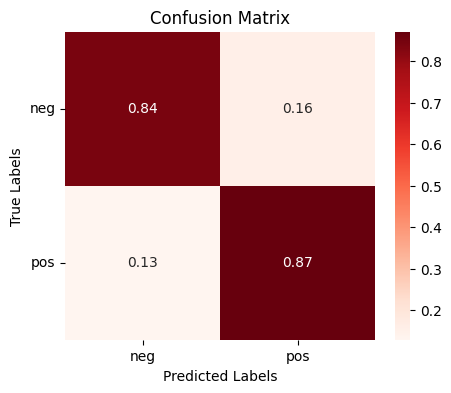

In [ ]:
plot_confusion_matrix(valid_labels, valid_preds, class_labels=list(my_config.id2label.values()))

In [ ]:
# log the Confusion Matrix to Wandb
wandb.log({"conf_mat": wandb.plot.confusion_matrix(
    preds=valid_preds, y_true=valid_labels,
    class_names=['neg', 'pos'])})


<font color = 'indianred'> *Get best checkpoint*</font>

In [ ]:
# After training, let us check the best checkpoint
# We need this for Inference
best_model_checkpoint_step = trainer.state.best_model_checkpoint.split('-')[-1]
print(f"The best model was saved at step {best_model_checkpoint_step}.")

The best model was saved at step 700.


In [ ]:
wandb.finish()

eval/accuracy,▁▃▅▆▆▇▇▇████████
eval/f1,▁▃▅▆▆▇▇▇████████
eval/loss,█▆▄▃▂▂▁▁▁▁▁▁▁▁▁▁
eval/runtime,▅▃▄▃▇▁▂█▁▁▆▃▁▄▄▃
eval/samples_per_second,▃▆▅▆▂█▆▁██▃▅▇▅▅▅
eval/steps_per_second,▃▆▅▆▂█▆▁██▃▅▇▅▅▅
train/epoch,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇████
train/global_step,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇█████
train/grad_norm,█▅▃▂▂▃▃▃▁▂▃▂▂▂▄
train/learning_rate,██▇▆▆▅▅▅▄▄▃▃▂▂▁
train/loss,█▆▅▄▄▄▃▂▂▂▂▁▁▁▁


## <Font color = 'indianred'> **6. Performance on Test Set**

In the Model Evaluation stage, attention shifts to assessing the trained model's performance on unseen data, usually the test dataset. This phase generally follows the model training, marking a critical step in confirming the model's effectiveness and generalizability.

This stage is critical for assessing how well the model generalizes beyond the data it was trained on. The process involves:

1. **Loading the Best Model**: Load the checkpoint of the best model across different experiments. IN pour case we will select the best saved model from previos run.

2. **Setting Up the Trainer for Inference**: A new `Trainer` instance is configured with `TrainingArguments`. Here, training is disabled (`do_train = False`), and evaluation is enabled (`do_eval=True`), with other settings adjusted for the inference context, such as batch size and disabling of result logging.

3. **Evaluation and Prediction**: Using the `Trainer`, the model's performance is evaluated on the test dataset (`testset`). The `evaluate()` method computes metrics to assess the model, and `predict()` generates predictions, which are further processed to obtain final class labels and metrics.

4. **Visualizing Performance**: The confusion matrix is plotted to visually represent the model's classification accuracy on the test data, providing insights into its strengths and weaknesses in predicting different classes.

<Font color = 'indianred'> **Load Model from checkpoint**

In [ ]:
# Define the path to the best model checkpoint
# 'model_checkpoint' variable is constructed using the model folder path and the checkpoint step
# This step is identified as having the best model performance during training
model_checkpoint = model_folder/f'checkpoint-{best_model_checkpoint_step}'


In [ ]:
# Instantiate the CustomMLP model with predefined configurations
# 'my_config' is an instance of the CustomConfig class, containing specific model settings like
# vocabulary size, embedding dimensions, etc.
model = CustomMLP(my_config)


In [ ]:
model

CustomMLP(
  (embedding_bag): EmbeddingBag(36153, 300, mode='mean')
  (layers): Sequential(
    (0): Linear(in_features=300, out_features=200, bias=True)
    (1): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=100, out_features=2, bias=True)
  )
)

In [ ]:
# Load the pre-trained weights into the CustomMLP model from the specified checkpoint
# 'model_checkpoint' refers to the path where the model's best-performing state is saved
# This step ensures the model is initialized with weights from its most effective training state
model = model.from_pretrained(model_checkpoint, config = my_config)


In [ ]:
model

CustomMLP(
  (embedding_bag): EmbeddingBag(36153, 300, mode='mean')
  (layers): Sequential(
    (0): Linear(in_features=300, out_features=200, bias=True)
    (1): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=100, out_features=2, bias=True)
  )
)

<Font color = 'indianred'> **Instantiate Trainer for evaluation**

In [ ]:
# Create a partial function 'collate_fn' using 'collate_batch' with 'my_vocab' set to 'imdb_vocab'
# This function will be used by the Trainer to process batches of data during evaluation
collate_fn = partial(collate_batch, my_vocab=imdb_vocab)

# Configure training arguments for model evaluation
# 'output_dir' specifies where to save the results
# 'per_device_eval_batch_size' sets the batch size for evaluation, adjusted based on available GPU memory
# 'do_train = False' and 'do_eval=True' indicate that training is not performed, but evaluation is
# 'remove_unused_columns=False' ensures that all columns in the dataset are retained during evaluation
# 'report_to=[]' disables logging to external services like Weights & Biases

training_args = TrainingArguments(
    output_dir="./results",
    per_device_eval_batch_size=16,
    do_train=False,
    do_eval=True,
    remove_unused_columns=False,
    report_to=[]
)


In [ ]:
# Initialize the Trainer with the specified model and training arguments
# 'model' is the CustomMLP model loaded with pre-trained weights
# 'training_args' contains the configurations for evaluation, including batch sizes and output directory
# 'eval_dataset' is set to 'testset', which is the dataset used for evaluating the model
# 'data_collator' is assigned 'collate_fn', the function for processing batches of data
# 'compute_metrics' is a function that calculates evaluation metrics like accuracy and F1 score

trainer = Trainer(
    model=model,
    args=training_args,
    eval_dataset=testset,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
)


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [ ]:
trainer.evaluate()

{'eval_loss': 0.37968242168426514,
 'eval_accuracy': 0.8432,
 'eval_f1': 0.8424057248532605,
 'eval_runtime': 9.0882,
 'eval_samples_per_second': 2750.83,
 'eval_steps_per_second': 171.982}

In [ ]:
test_predictions = trainer.predict(testset)

In [ ]:
test_predictions._fields


('predictions', 'label_ids', 'metrics')

In [ ]:
test_predictions.metrics

{'test_loss': 0.37968242168426514,
 'test_accuracy': 0.8432,
 'test_f1': 0.8424057248532605,
 'test_runtime': 13.459,
 'test_samples_per_second': 1857.492,
 'test_steps_per_second': 116.13}

In [ ]:
test_predictions.label_ids

array([1, 1, 1, ..., 0, 0, 0])

In [ ]:
test_preds = np.argmax(test_predictions.predictions, axis=1)
test_labels = np.array(test_predictions.label_ids)

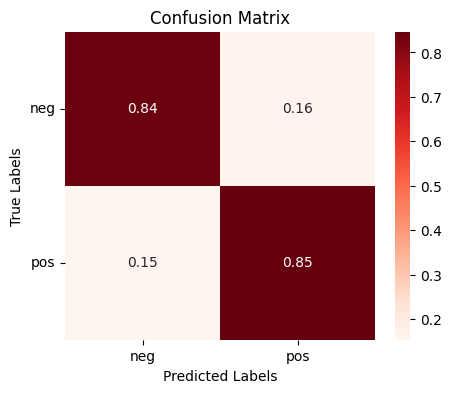

In [ ]:
plot_confusion_matrix(test_preds, test_labels, class_labels=list(my_config.id2label.values()))

## <Font color = 'indianred'> **7. Model Inference**
Model inference is the stage in the machine learning process where a trained model is used to make predictions on new, unseen data. Unlike the training or evaluation phases, labels are not required at this stage, as the primary goal is to apply the model's learned patterns and knowledge to generate predictions.




In [ ]:
sample_X = X_test_cleaned[0:5]

*Step 1. Preprocessing*

In [ ]:
device = 'cpu'
# Convert the list of texts into a list of lists; each inner list contains the vocabulary indices for a text
list_of_list_of_indices = [tokenizer(text, imdb_vocab) for text in sample_X]

# Compute the offsets for each text in the concatenated tensor
offsets = [0] + [len(i) for i in list_of_list_of_indices]
offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)

# Concatenate all text indices into a single tensor
indices = torch.cat([torch.tensor(i, dtype=torch.int64) for i in list_of_list_of_indices])

*Step 2: Get Predictions*

In [ ]:
# move model to appropriate device
model.to(device)

# put model in evaluation mode
model.eval()

# get outputs (logits) from model
outputs = model(indices, offsets)
outputs

SequenceClassifierOutput(loss=None, logits=tensor([[-2.0745,  1.9437],
        [-1.7778,  1.7444],
        [-1.1749,  1.2411],
        [ 1.2903, -0.7448],
        [-2.0448,  2.1057]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [ ]:
outputs.logits

tensor([[-2.0745,  1.9437],
        [-1.7778,  1.7444],
        [-1.1749,  1.2411],
        [ 1.2903, -0.7448],
        [-2.0448,  2.1057]], grad_fn=<AddmmBackward0>)

*Step 3: Post Processing*

In [ ]:
# get predicted labels
predictions = torch.argmax(outputs.logits, dim = 1)

# mapping for class labels
mapping = model.config.id2label

predicted_label_names = list(map(mapping.get, predictions.tolist()))

print(predicted_label_names)

['pos', 'pos', 'pos', 'neg', 'pos']
